In [1]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/mhealth/study/test_submission/'
import os
os.chdir(path)
os.getcwd()

'/content/drive/MyDrive/mhealth/study/test_submission'

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from IPython.display import Image, display, Markdown, HTML
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

In [5]:
base_dir = "/content/drive/MyDrive/mhealth/study/test_submission"
print(f"Using data from: {base_dir}")

def create_directory_if_not_exists(path):
    """Create directory if it doesn't exist"""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")

def load_participant_data(participant_id):
    """Load merged sensor data for a participant"""
    data_file = os.path.join(base_dir, participant_id, 'data', 'merged_sensor_data.csv')
    if os.path.exists(data_file):
        df = pd.read_csv(data_file)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    else:
        print(f"Error: Data file not found for {participant_id}")
        return None


Using data from: /content/drive/MyDrive/mhealth/study/test_submission


In [6]:

def extract_activity_data(df, participant_id):
    """Extract data segments for each activity type"""

    activities_file = os.path.join(base_dir, participant_id, 'tests', 'activity_sessions.json')

    if not os.path.exists(activities_file):
        if participant_id == 'p1':
            sessions = {
                'resting': {'start': '2025-03-11 23:42:00', 'end': '2025-03-11 23:48:00'},
                'boring': {'start': '2025-03-11 23:50:00', 'end': '2025-03-11 23:55:00'},
                'exciting': {'start': '2025-03-11 23:57:00', 'end': '2025-03-12 00:02:00'}
            }
        else:  # p2
            sessions = {
                'resting': {'start': '2025-03-12 00:15:29', 'end': '2025-03-12 00:20:29'},
                'boring': {'start': '2025-03-12 00:21:00', 'end': '2025-03-12 00:26:00'},
                'exciting': {'start': '2025-03-12 00:26:50', 'end': '2025-03-12 00:31:50'}
            }
    else:
        with open(activities_file, 'r') as f:
            sessions = json.load(f)

    activity_data = {}
    for activity_type, session in sessions.items():
        start_time = pd.to_datetime(session['start'])
        end_time = pd.to_datetime(session['end'])

        # Filter data for this activity
        activity_segment = df[(df['timestamp'] >= start_time) &
                             (df['timestamp'] <= end_time)].copy()

        # Add activity type as a column
        activity_segment['activity_type'] = activity_type
        activity_data[activity_type] = activity_segment

    # Combine all activities into one dataframe
    combined_df = pd.concat(activity_data.values())
    return combined_df, activity_data


In [7]:
p1_dir = os.path.join(base_dir, 'p1')
p2_dir = os.path.join(base_dir, 'p2')

if not os.path.exists(p1_dir) or not os.path.exists(p2_dir):
    print(f"Error: Could not find p1 and p2 directories in {base_dir}")
else:
    print(f"Found participant directories:\n- {p1_dir}\n- {p2_dir}")

    # Create correlation directories if they don't exist
    for participant in ['p1', 'p2']:
        corr_dir = os.path.join(base_dir, participant, 'correlation')
        create_directory_if_not_exists(corr_dir)

Found participant directories:
- /content/drive/MyDrive/mhealth/study/test_submission/p1
- /content/drive/MyDrive/mhealth/study/test_submission/p2
Created directory: /content/drive/MyDrive/mhealth/study/test_submission/p1/correlation
Created directory: /content/drive/MyDrive/mhealth/study/test_submission/p2/correlation


In [8]:
participant_data = {}
activity_data = {}
all_activity_data = {}

for participant in ['p1', 'p2']:
    df = load_participant_data(participant)
    if df is not None:
        participant_data[participant] = df
        all_activity_data[participant], activity_data[participant] = extract_activity_data(df, participant)
        print(f"Loaded data for {participant}: {len(df)} rows")
        print(f"Activity data segments: {', '.join([f'{k}: {len(v)} rows' for k, v in activity_data[participant].items()])}")
    else:
        print(f"Failed to load data for {participant}")

Loaded data for p1: 11472 rows
Activity data segments: resting: 2727 rows, boring: 3001 rows, exciting: 3001 rows
Loaded data for p2: 10983 rows
Activity data segments: resting: 3001 rows, boring: 3001 rows, exciting: 3001 rows


In [9]:
sensor_columns = [
    'wrist_accel_magnitude',
    'ankle_accel_magnitude',
    'ecg_value',
    'orientation'
]

sensor_labels = {
    'wrist_accel_magnitude': 'Wrist Acceleration',
    'ankle_accel_magnitude': 'Ankle Acceleration',
    'ecg_value': 'ECG Value',
    'orientation': 'Face Orientation'
}

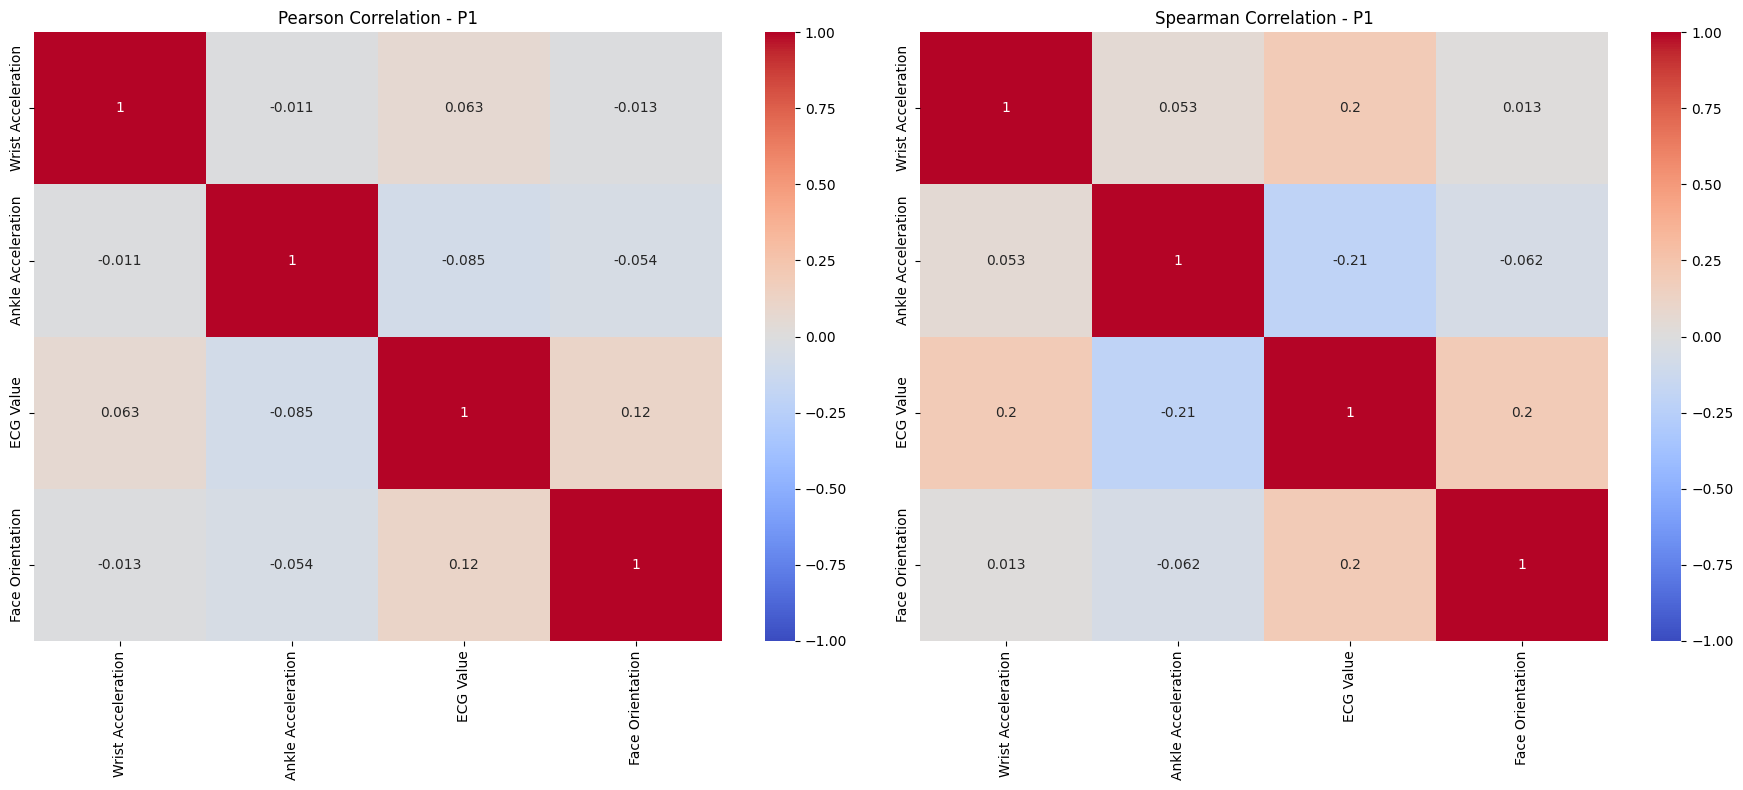

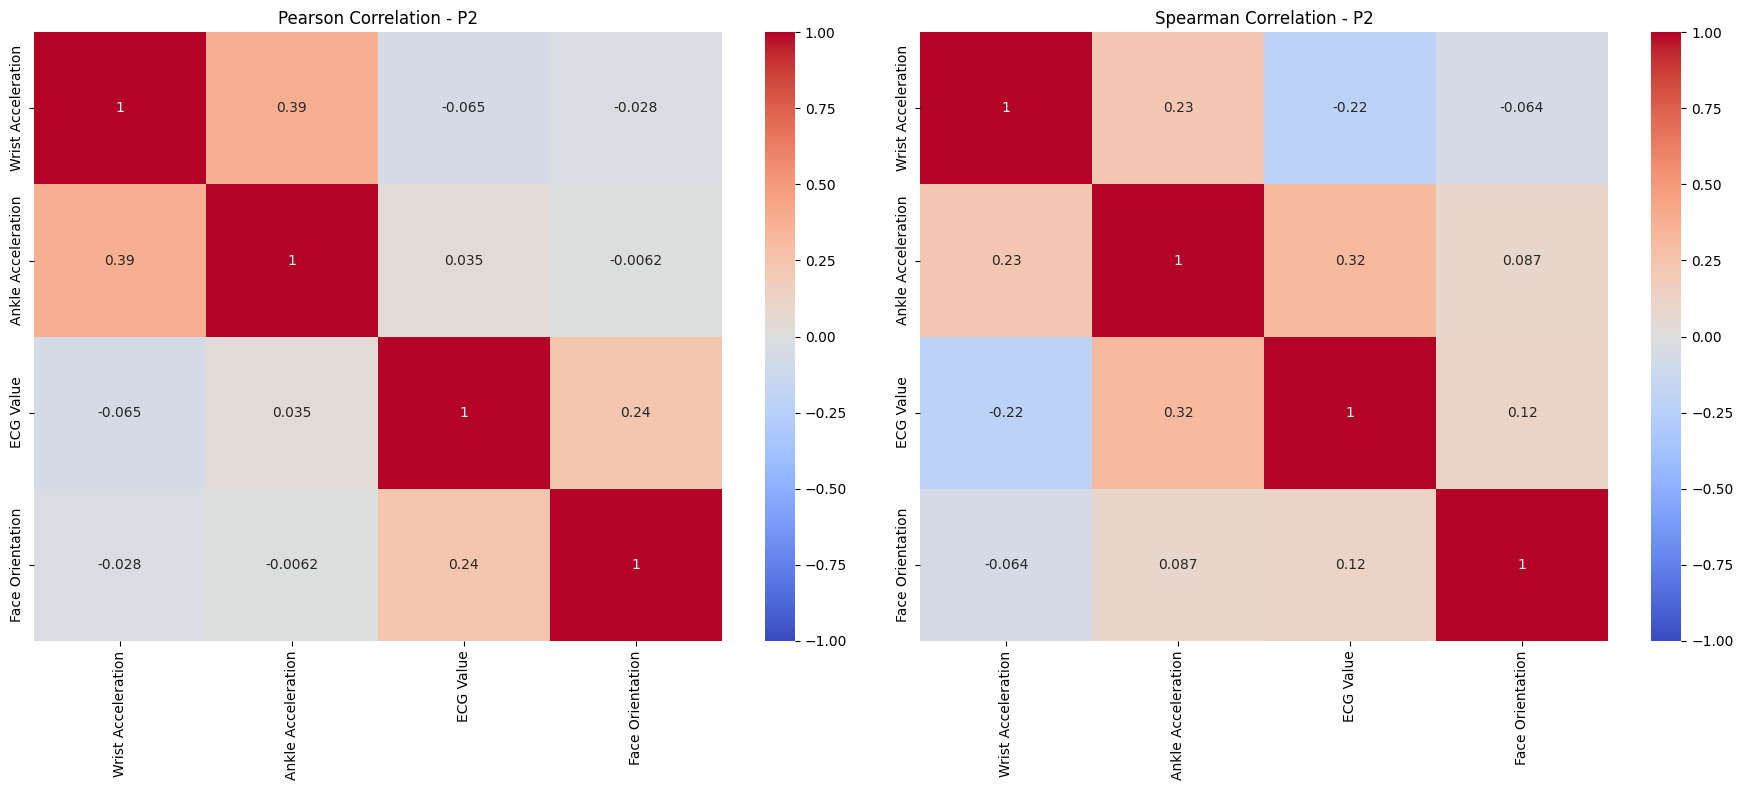

In [10]:
for participant in ['p1', 'p2']:
    if participant not in all_activity_data:
        continue

    # Create correlation matrices (both Pearson and Spearman)
    df = all_activity_data[participant][sensor_columns]

    # Pearson correlation
    pearson_corr = df.corr(method='pearson')

    # Spearman correlation
    spearman_corr = df.corr(method='spearman')

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot Pearson correlation
    sns.heatmap(pearson_corr,
                annot=True,
                cmap='coolwarm',
                vmin=-1,
                vmax=1,
                ax=axes[0],
                xticklabels=[sensor_labels[col] for col in sensor_columns],
                yticklabels=[sensor_labels[col] for col in sensor_columns])
    axes[0].set_title(f'Pearson Correlation - {participant.upper()}')

    # Plot Spearman correlation
    sns.heatmap(spearman_corr,
                annot=True,
                cmap='coolwarm',
                vmin=-1,
                vmax=1,
                ax=axes[1],
                xticklabels=[sensor_labels[col] for col in sensor_columns],
                yticklabels=[sensor_labels[col] for col in sensor_columns])
    axes[1].set_title(f'Spearman Correlation - {participant.upper()}')

    plt.tight_layout()

    # Save figure
    corr_dir = os.path.join(base_dir, participant, 'correlation')
    overall_corr_path = os.path.join(corr_dir, 'overall_correlation.png')
    plt.savefig(overall_corr_path, dpi=300, bbox_inches='tight')

    # Display the figure
    plt.show()



    
    - The correlation matrices show the strength of relationships between different sensor measurements.
    - Pearson correlation measures linear relationships, while Spearman measures monotonic relationships.
    - Values close to 1 indicate strong positive correlation, values close to -1 indicate strong negative correlation.
    - Values close to 0 indicate little to no correlation.


In [12]:
pearson_csv_path = os.path.join(corr_dir, 'pearson_correlation.csv')
spearman_csv_path = os.path.join(corr_dir, 'spearman_correlation.csv')

pearson_corr.to_csv(pearson_csv_path)
spearman_corr.to_csv(spearman_csv_path)

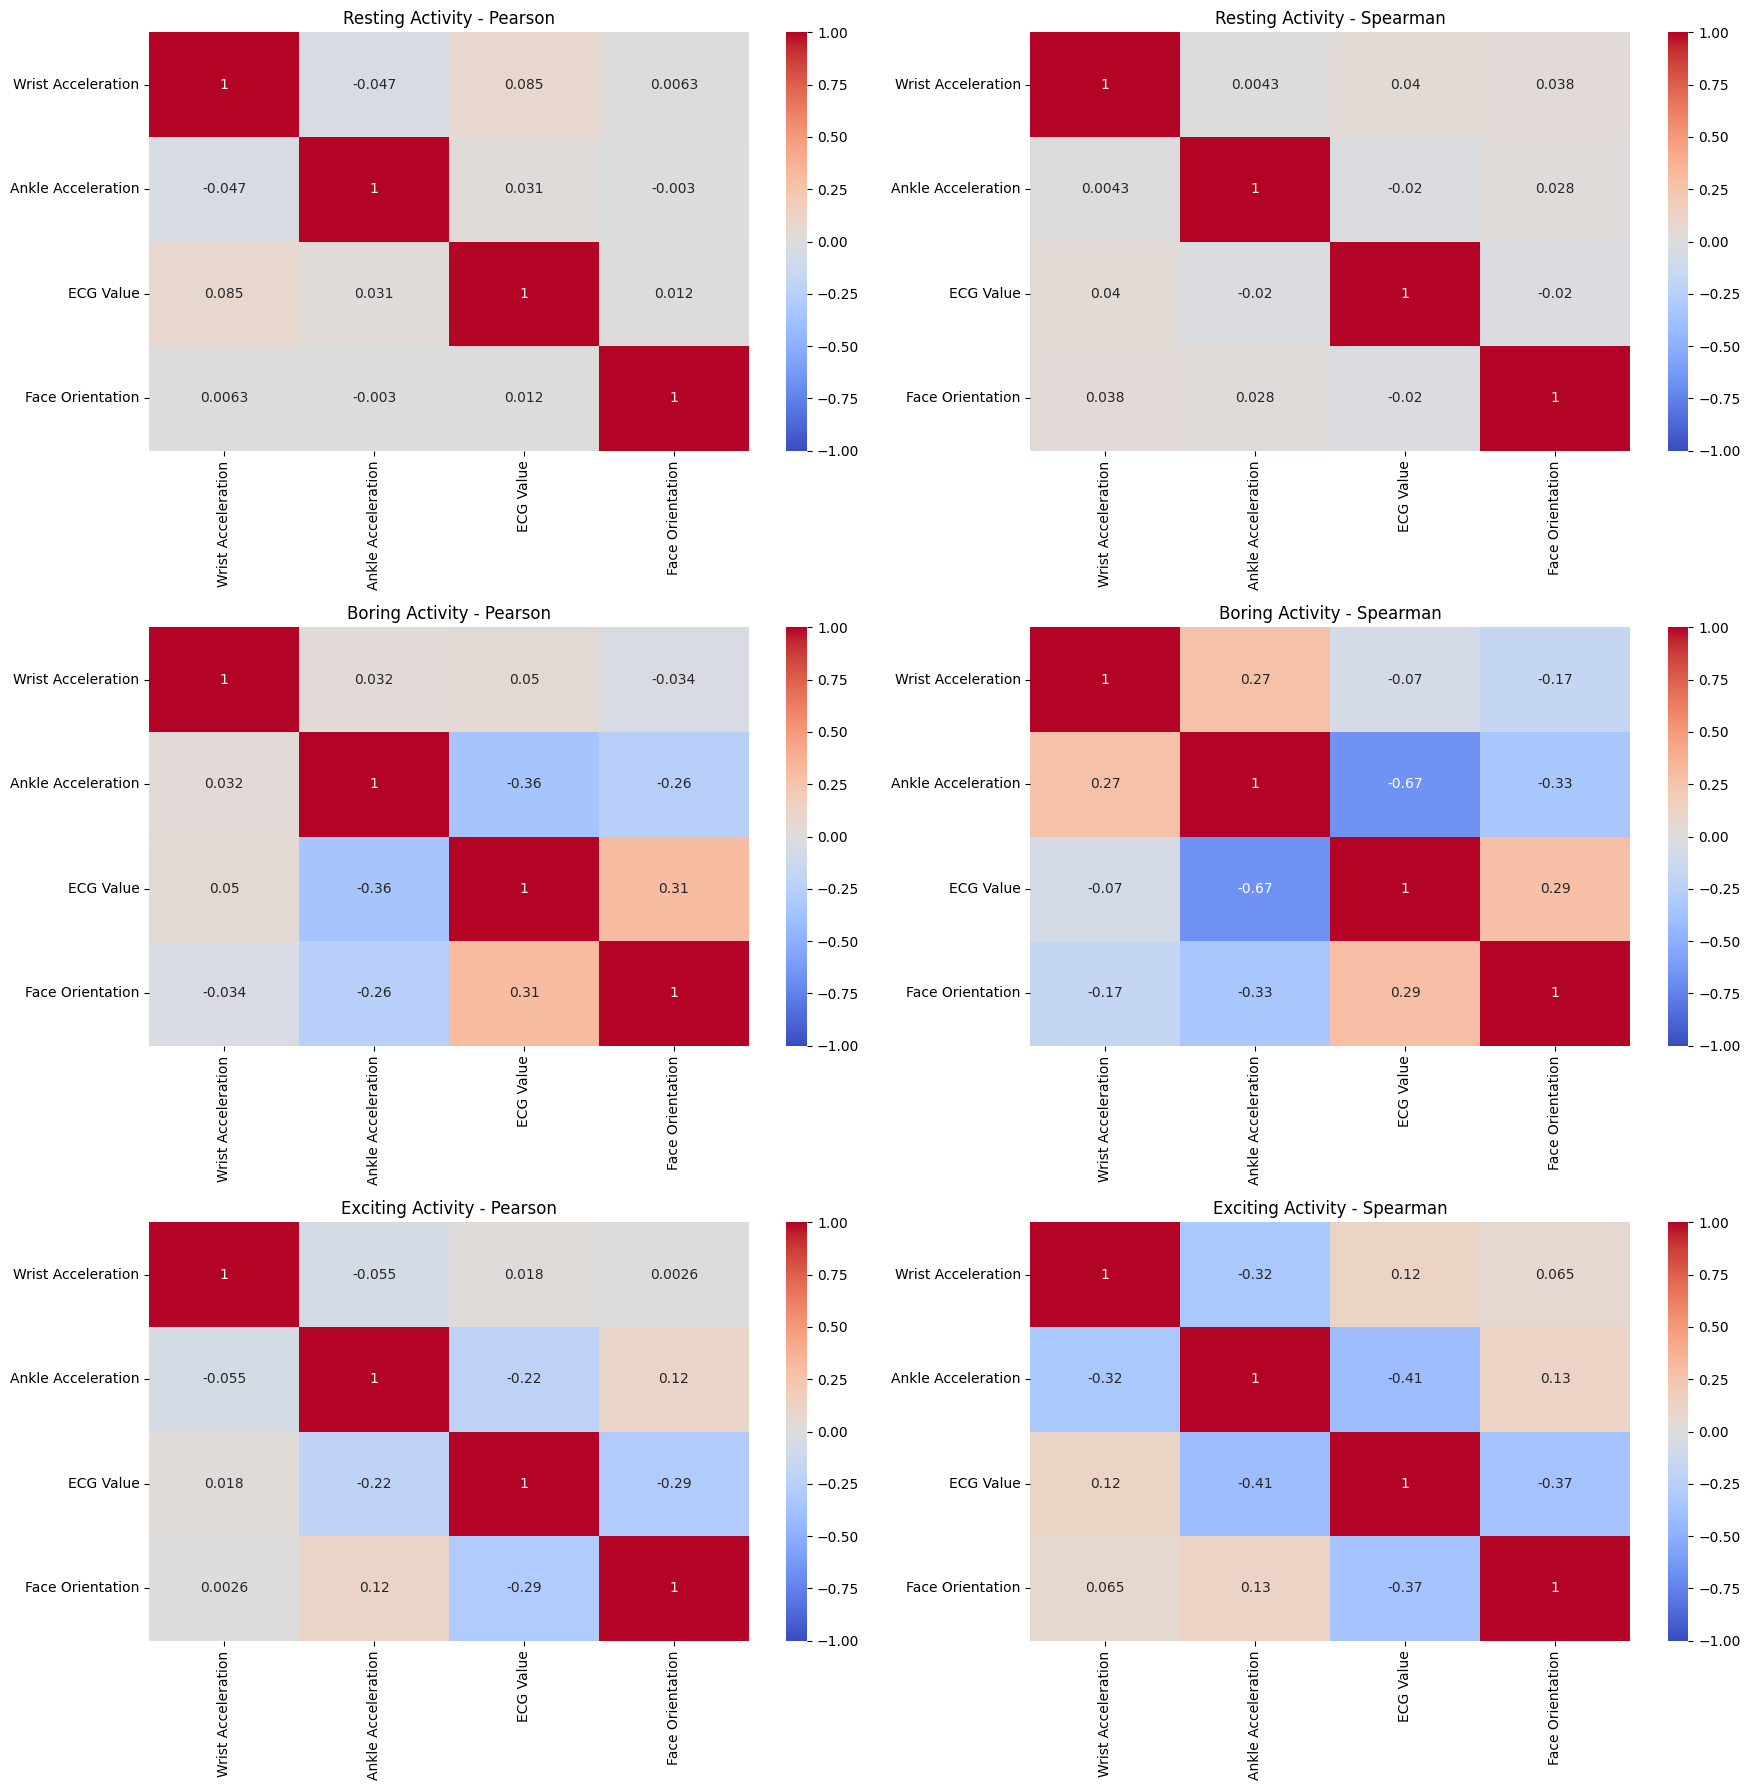

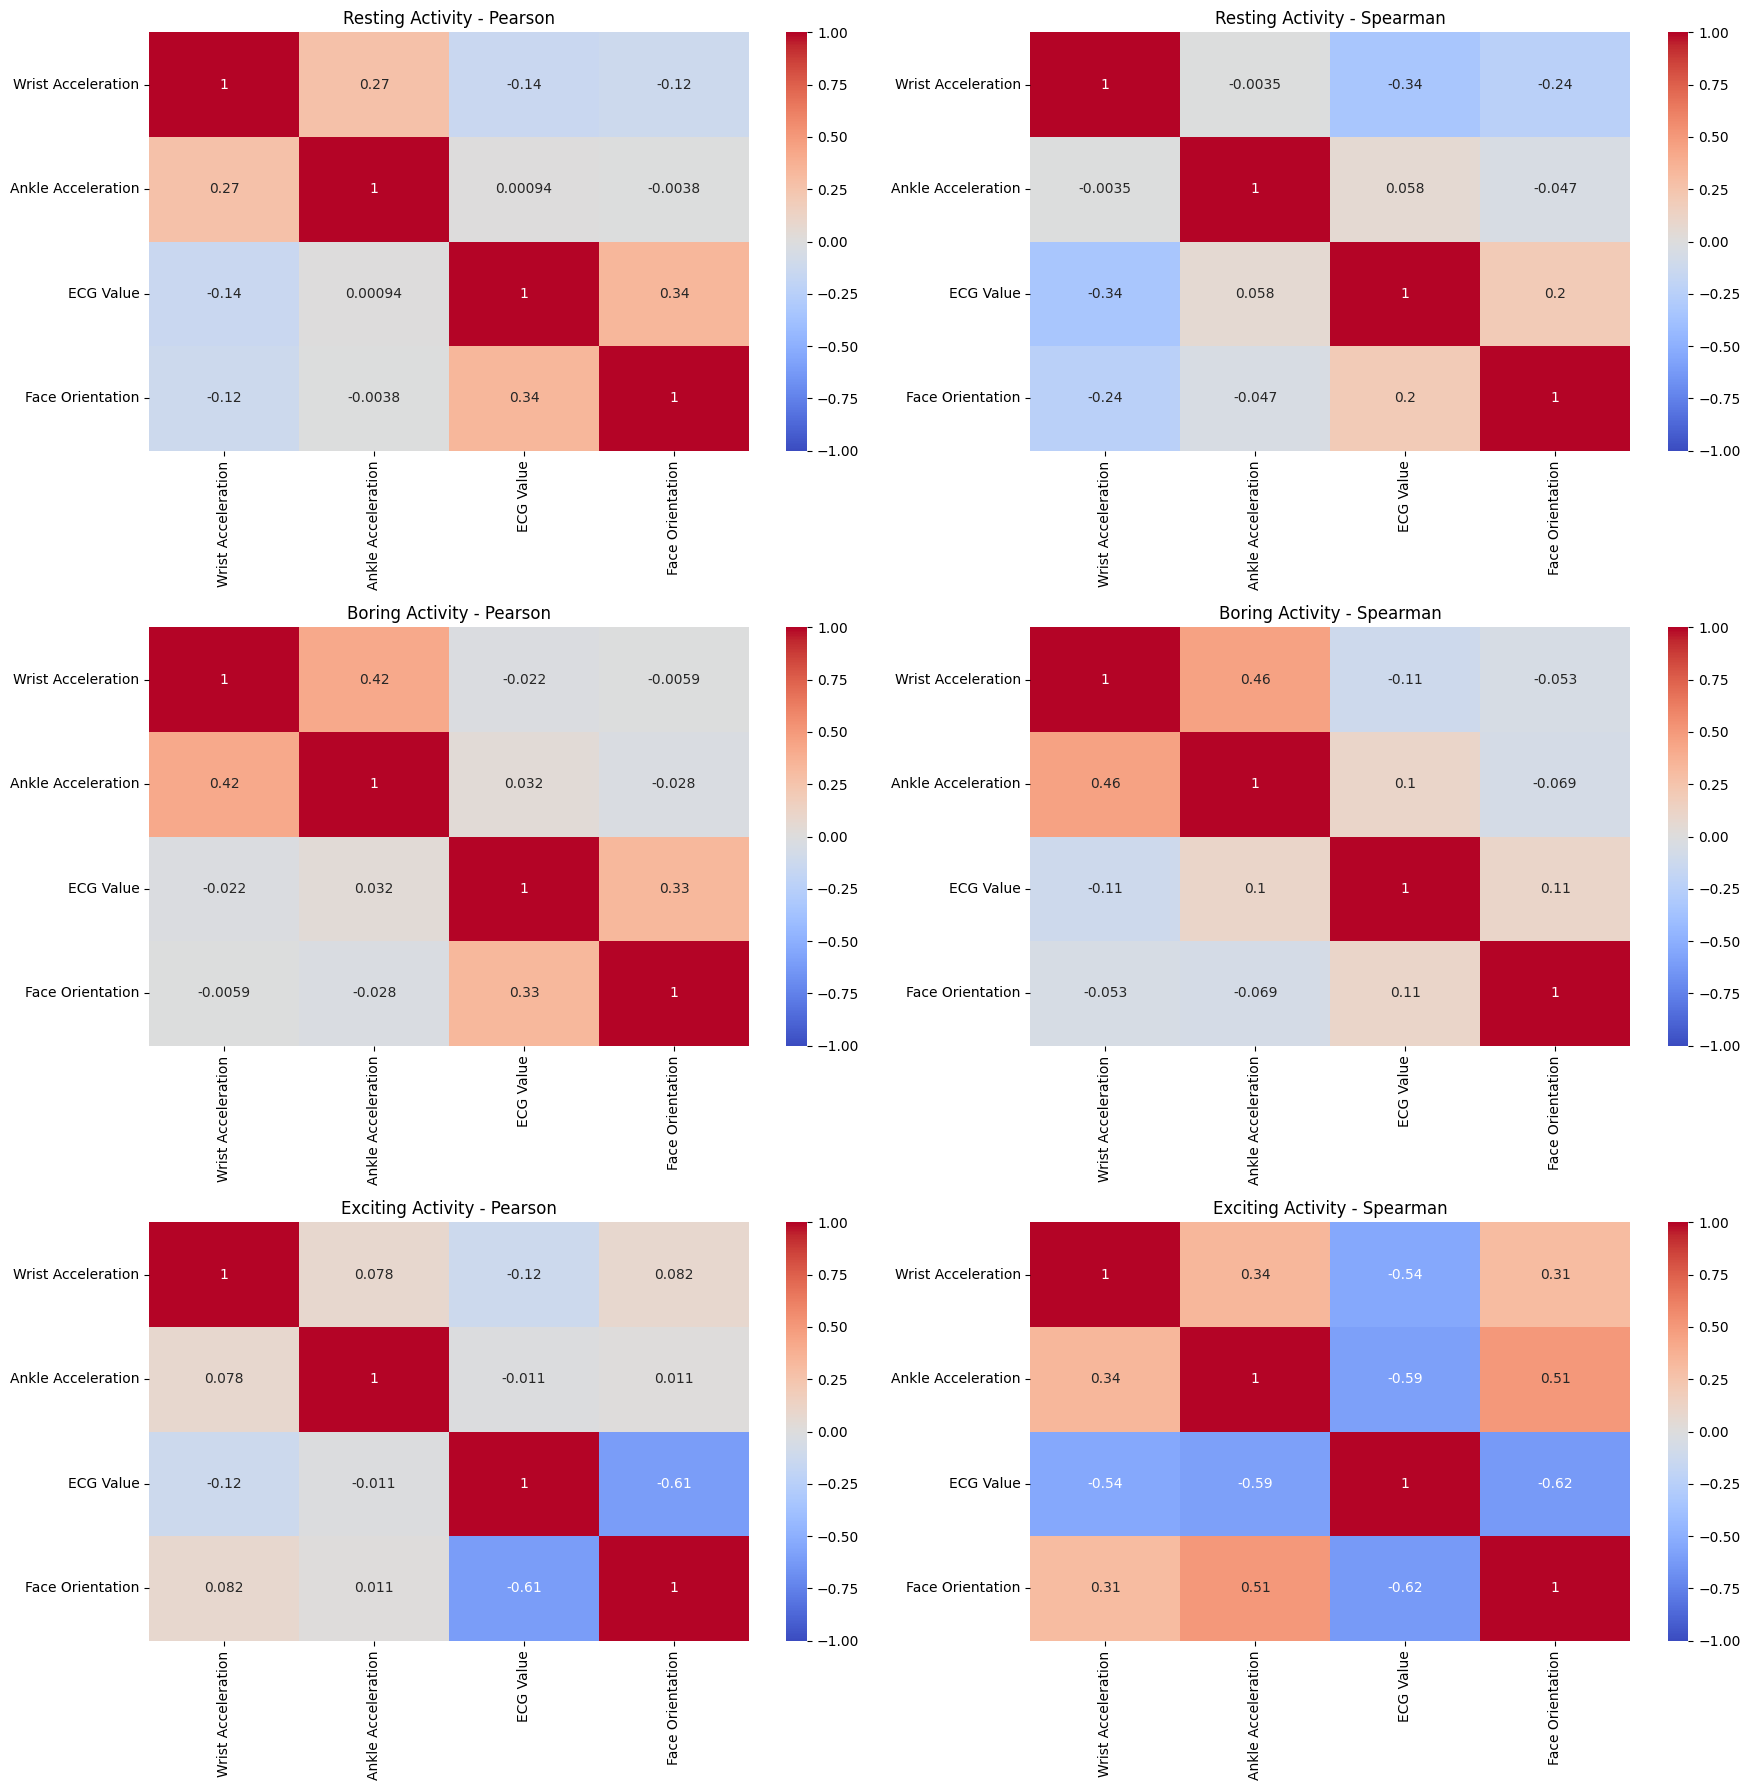

In [13]:
for participant in ['p1', 'p2']:
    if participant not in activity_data:
        continue


    fig, axes = plt.subplots(len(activity_data[participant]), 2,
                            figsize=(18, 6*len(activity_data[participant])))

    for i, (activity, df) in enumerate(activity_data[participant].items()):
        # Calculate correlations
        pearson_corr = df[sensor_columns].corr(method='pearson')
        spearman_corr = df[sensor_columns].corr(method='spearman')

        # Plot Pearson correlation
        sns.heatmap(pearson_corr,
                    annot=True,
                    cmap='coolwarm',
                    vmin=-1,
                    vmax=1,
                    ax=axes[i, 0],
                    xticklabels=[sensor_labels[col] for col in sensor_columns],
                    yticklabels=[sensor_labels[col] for col in sensor_columns])
        axes[i, 0].set_title(f'{activity.capitalize()} Activity - Pearson')

        # Plot Spearman correlation
        sns.heatmap(spearman_corr,
                    annot=True,
                    cmap='coolwarm',
                    vmin=-1,
                    vmax=1,
                    ax=axes[i, 1],
                    xticklabels=[sensor_labels[col] for col in sensor_columns],
                    yticklabels=[sensor_labels[col] for col in sensor_columns])
        axes[i, 1].set_title(f'{activity.capitalize()} Activity - Spearman')

        # Save individual activity correlation matrices
        corr_dir = os.path.join(base_dir, participant, 'correlation')
        pearson_csv_path = os.path.join(corr_dir, f'{activity}_pearson_correlation.csv')
        spearman_csv_path = os.path.join(corr_dir, f'{activity}_spearman_correlation.csv')

        pearson_corr.to_csv(pearson_csv_path)
        spearman_corr.to_csv(spearman_csv_path)

    plt.tight_layout()

    # Save figure
    activity_corr_path = os.path.join(corr_dir, 'activity_correlation.png')
    plt.savefig(activity_corr_path, dpi=300, bbox_inches='tight')

    # Display the figure
    plt.show()


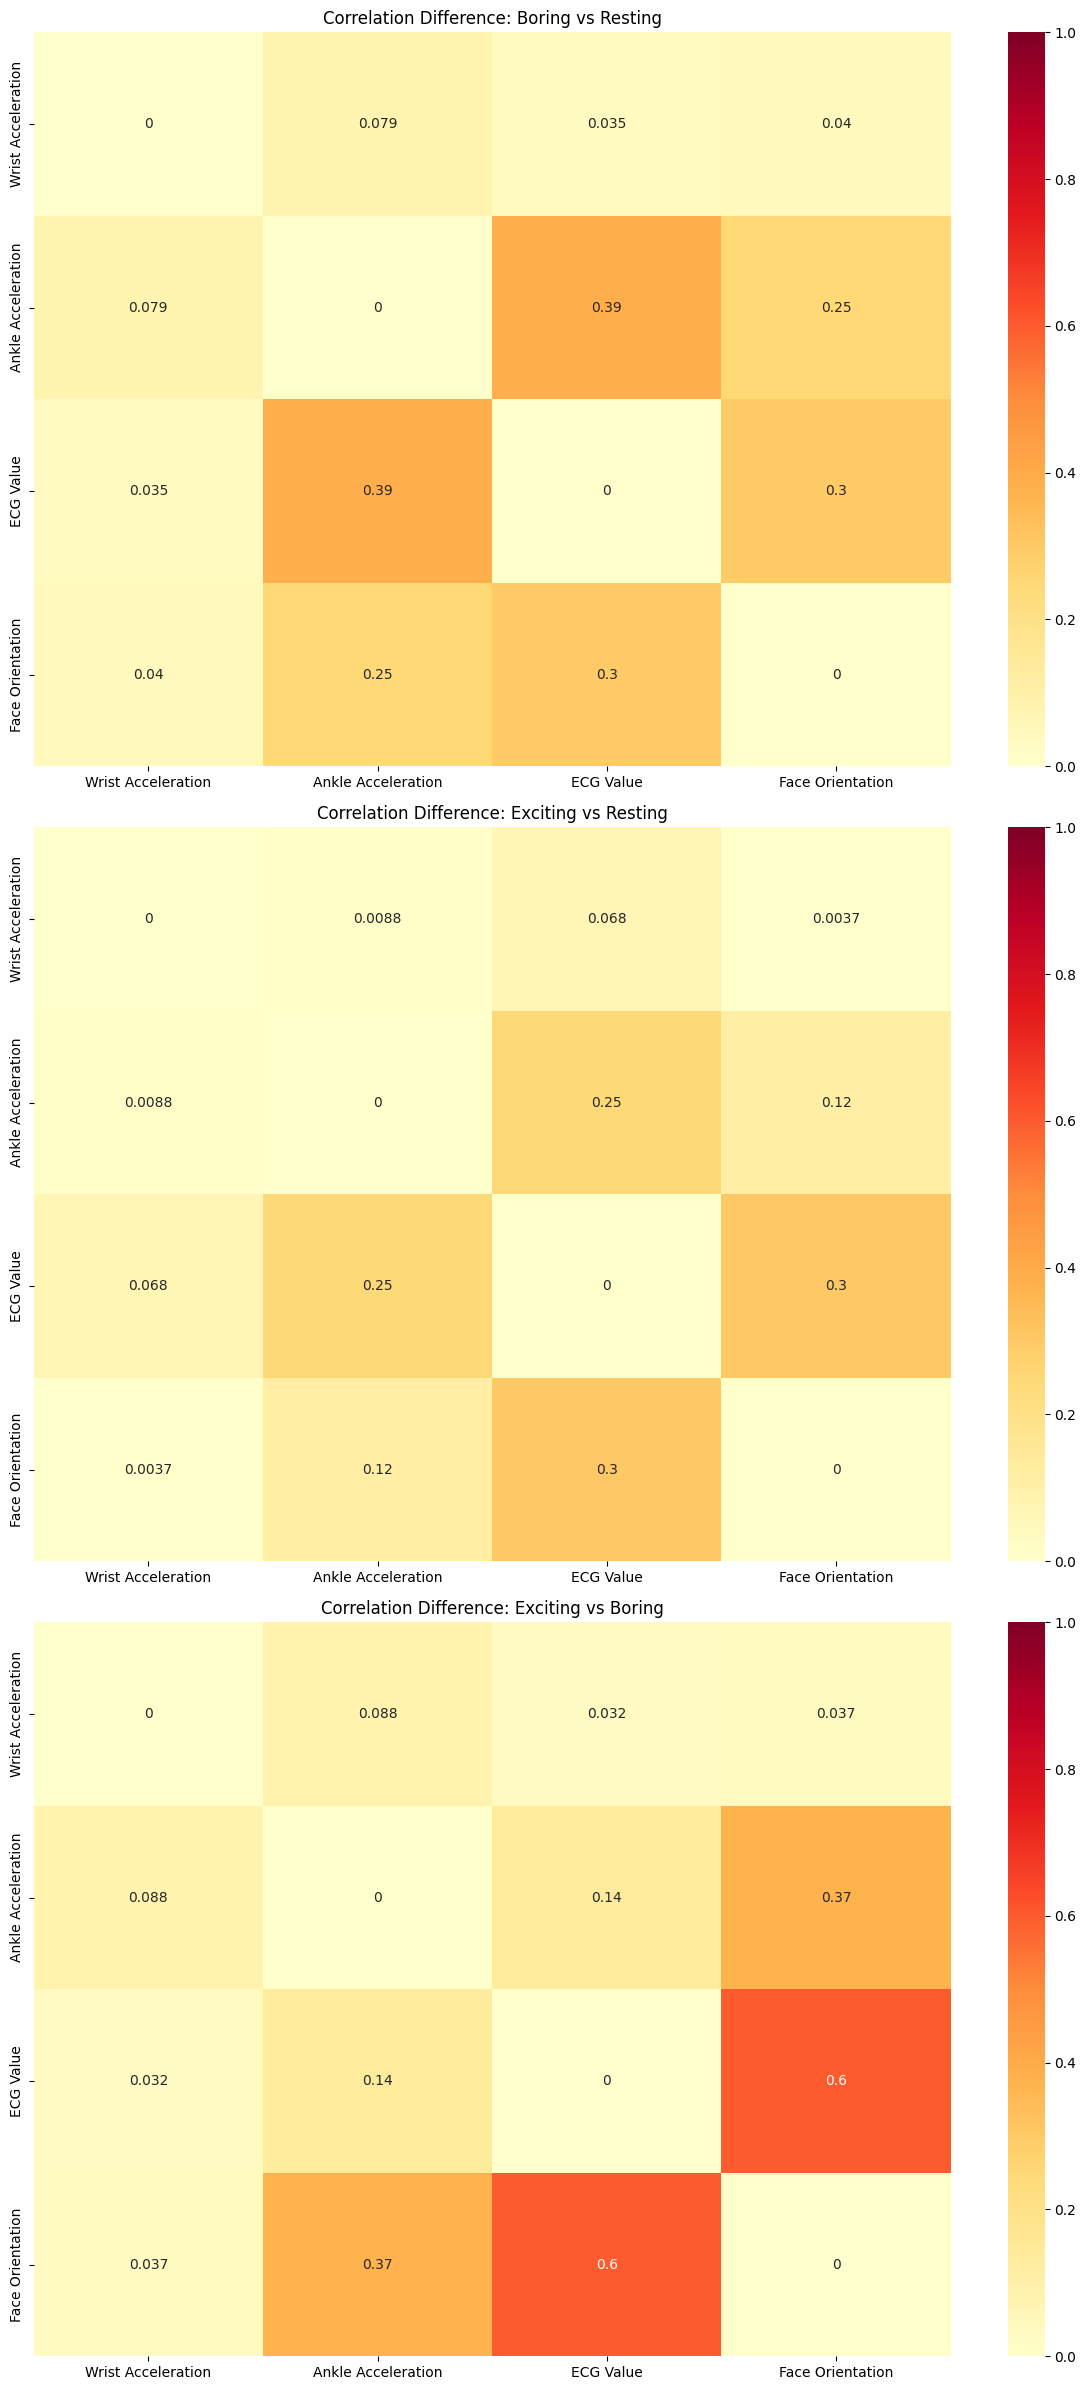

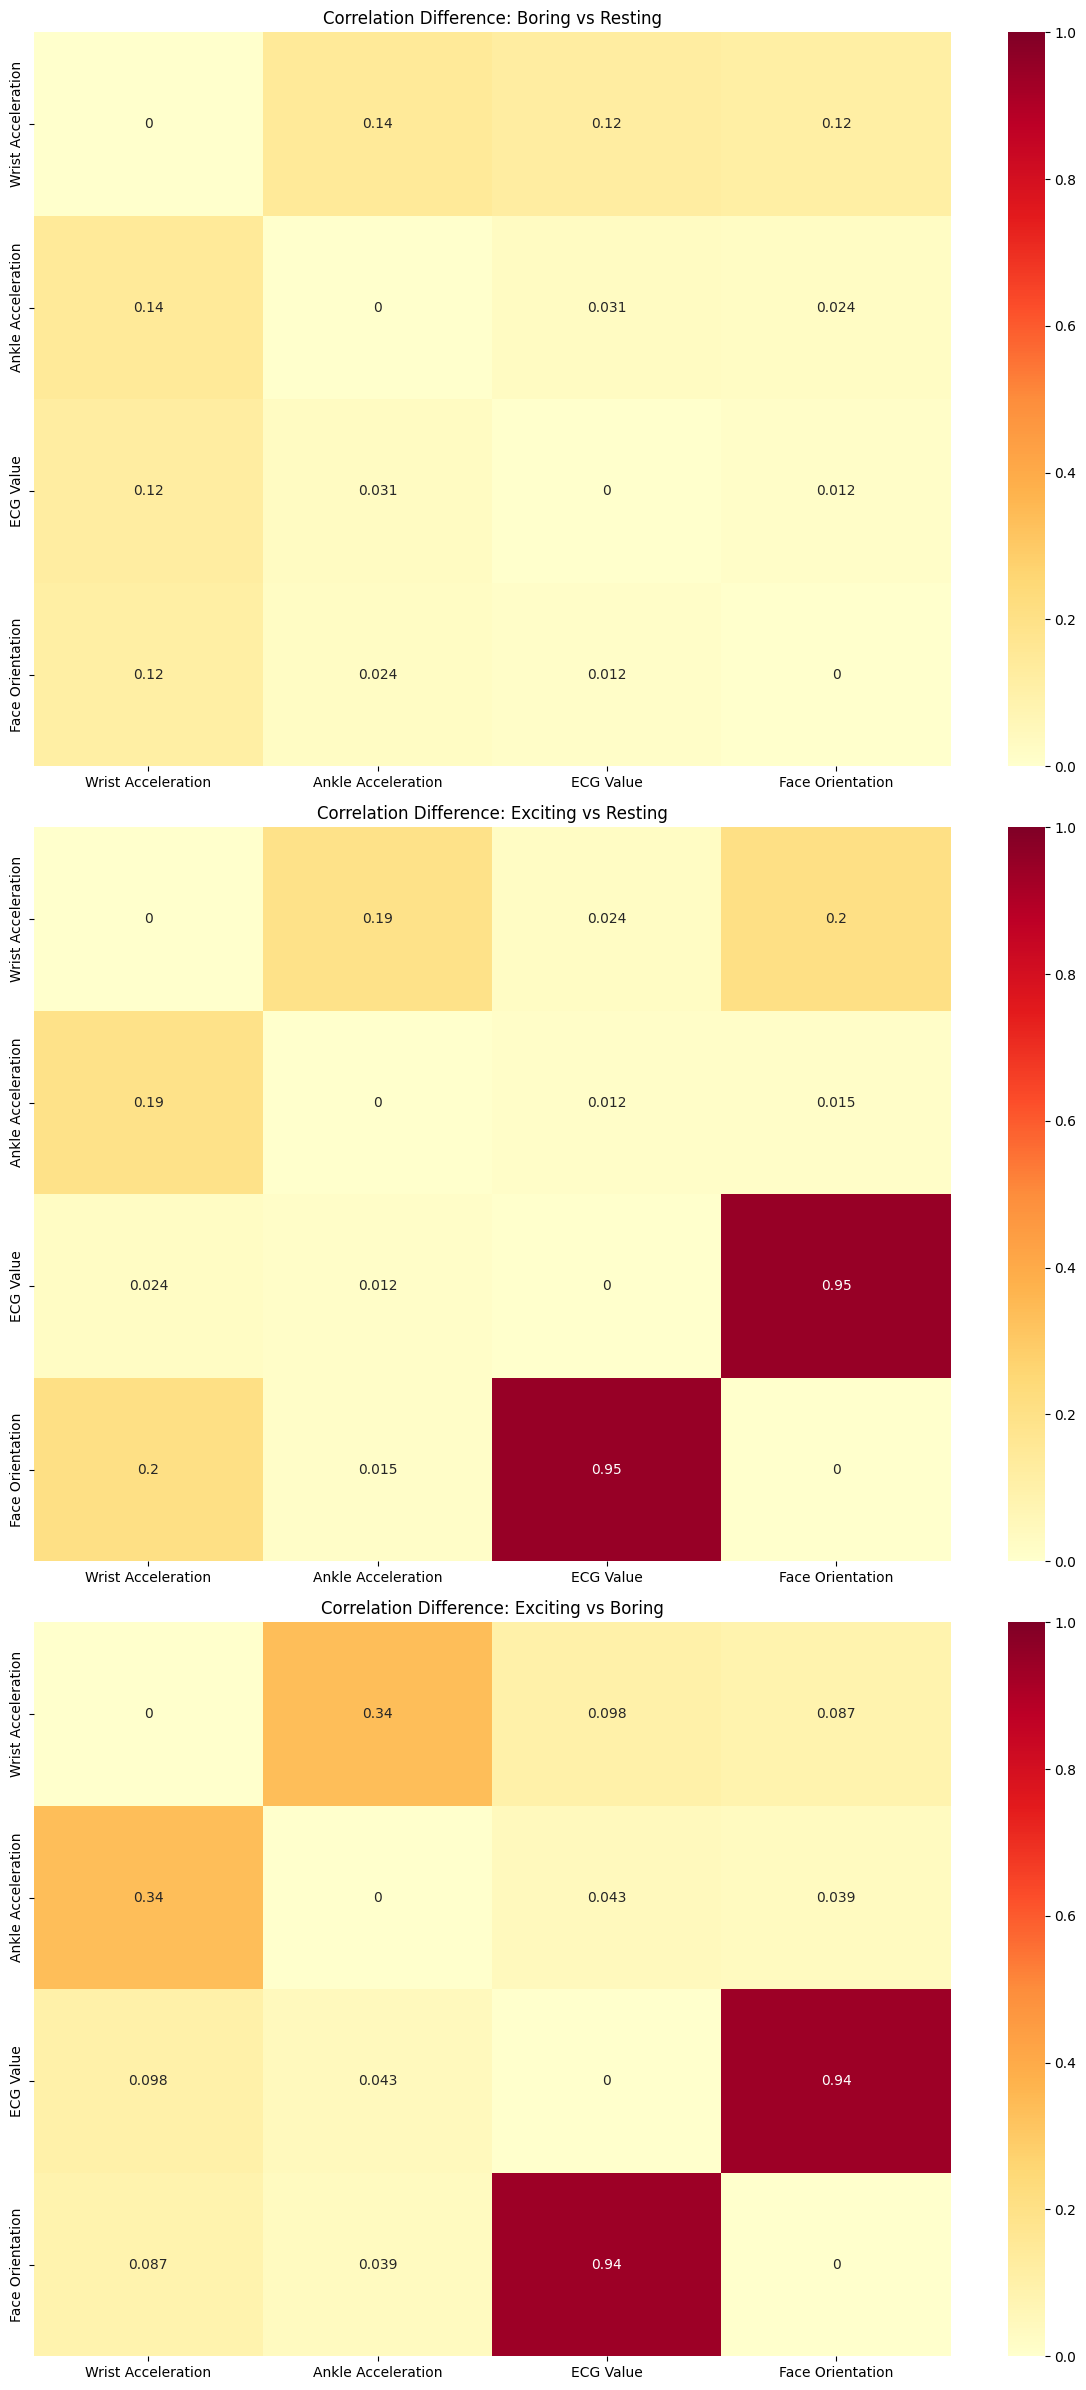

In [14]:
for participant in ['p1', 'p2']:
    if participant not in activity_data:
        continue

    activities = list(activity_data[participant].keys())

    # Create pairs of activities
    activity_pairs = [(activities[i], activities[j])
                     for i in range(len(activities))
                     for j in range(i+1, len(activities))]

    # Create a figure with subplots for each pair
    fig, axes = plt.subplots(len(activity_pairs), 1,
                            figsize=(12, 8*len(activity_pairs)))

    # If there's only one pair, axes won't be an array
    if len(activity_pairs) == 1:
        axes = [axes]

    for i, (act1, act2) in enumerate(activity_pairs):
        # Get correlation matrices for each activity
        corr1 = activity_data[participant][act1][sensor_columns].corr()
        corr2 = activity_data[participant][act2][sensor_columns].corr()

        # Calculate absolute difference
        diff = (corr2 - corr1).abs()

        # Plot difference
        sns.heatmap(diff,
                    annot=True,
                    cmap='YlOrRd',
                    vmin=0,
                    vmax=1,
                    ax=axes[i],
                    xticklabels=[sensor_labels[col] for col in sensor_columns],
                    yticklabels=[sensor_labels[col] for col in sensor_columns])
        axes[i].set_title(f'Correlation Difference: {act2.capitalize()} vs {act1.capitalize()}')

    plt.tight_layout()

    # Save figure
    diff_corr_path = os.path.join(base_dir, participant, 'correlation', 'correlation_differences.png')
    plt.savefig(diff_corr_path, dpi=300, bbox_inches='tight')

    # Display the figure
    plt.show()

In [16]:
def create_pairwise_plots(participant_id):
    """Create pairwise scatter plots for a participant"""

    if participant_id not in all_activity_data:
        print(f"No data available for {participant_id}")
        return

    df = all_activity_data[participant_id]

    # Define colors for each activity type
    activity_colors = {
        'resting': 'green',
        'boring': 'orange',
        'exciting': 'red'
    }

    # Create a figure with multiple subplots for each pair of sensors
    sensor_pairs = [(i, j) for i in range(len(sensor_columns)) for j in range(i+1, len(sensor_columns))]
    n_pairs = len(sensor_pairs)

    # Create grid of subplots
    n_cols = 2
    n_rows = (n_pairs + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    # Create scatter plots for each pair
    for i, (idx1, idx2) in enumerate(sensor_pairs):
        col1 = sensor_columns[idx1]
        col2 = sensor_columns[idx2]

        label1 = sensor_labels[col1]
        label2 = sensor_labels[col2]

        ax = axes[i]

        # Plot each activity type with different colors
        for activity, color in activity_colors.items():
            activity_df = df[df['activity_type'] == activity]
            ax.scatter(activity_df[col1], activity_df[col2],
                      c=color, alpha=0.6, label=activity.capitalize())

        # Calculate and display correlations
        pearson, _ = pearsonr(df[col1], df[col2])
        spearman, _ = spearmanr(df[col1], df[col2])

        ax.set_title(f'{label1} vs {label2}\n'
                    f'Pearson: {pearson:.2f}, Spearman: {spearman:.2f}')
        ax.set_xlabel(label1)
        ax.set_ylabel(label2)

        # Add legend
        if i == 0:
            ax.legend()

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()

    # Save figure
    pairwise_path = os.path.join(base_dir, participant_id, 'correlation', 'pairwise_relationships.png')
    plt.savefig(pairwise_path, dpi=300, bbox_inches='tight')

    # Display the figure
    plt.show()

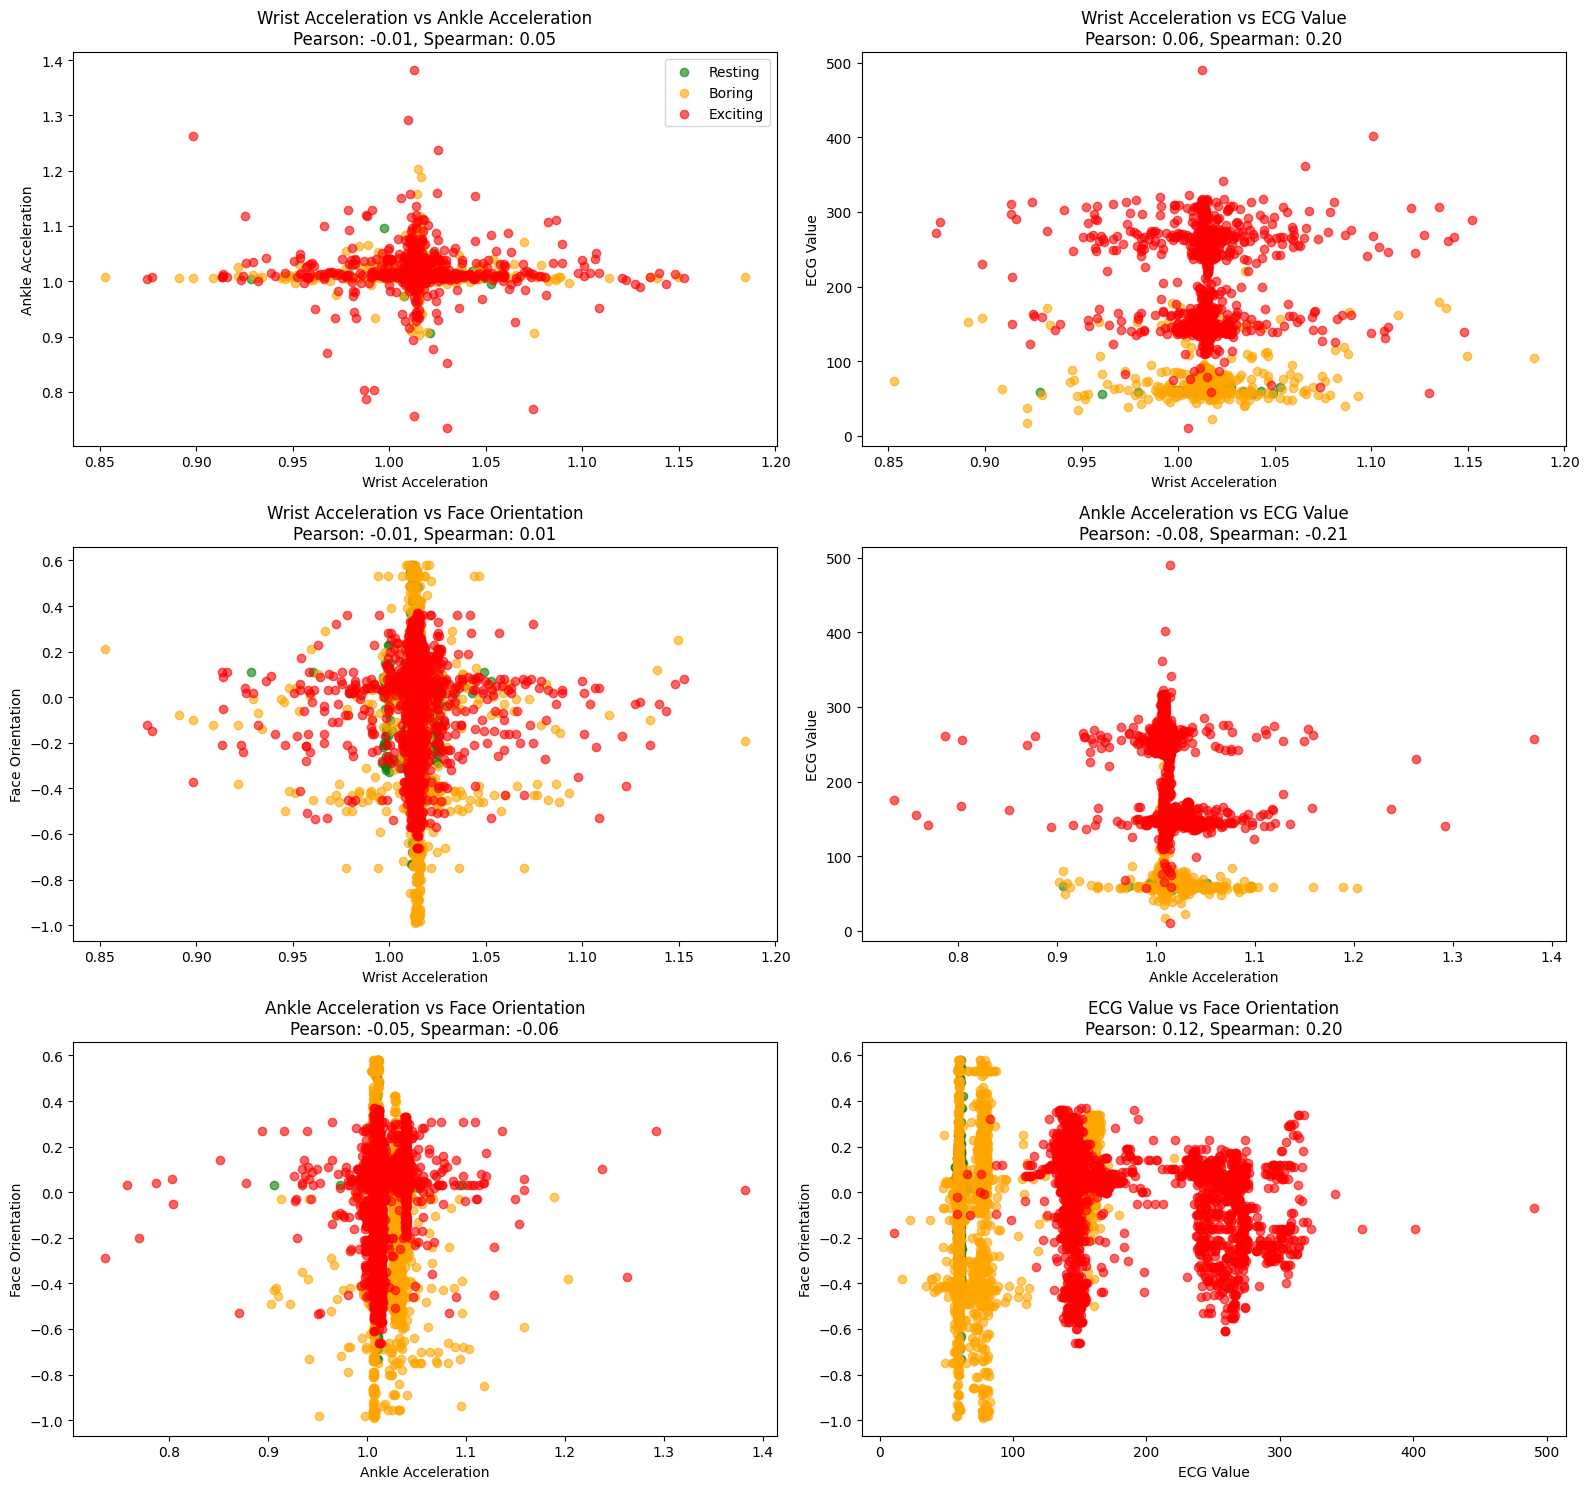

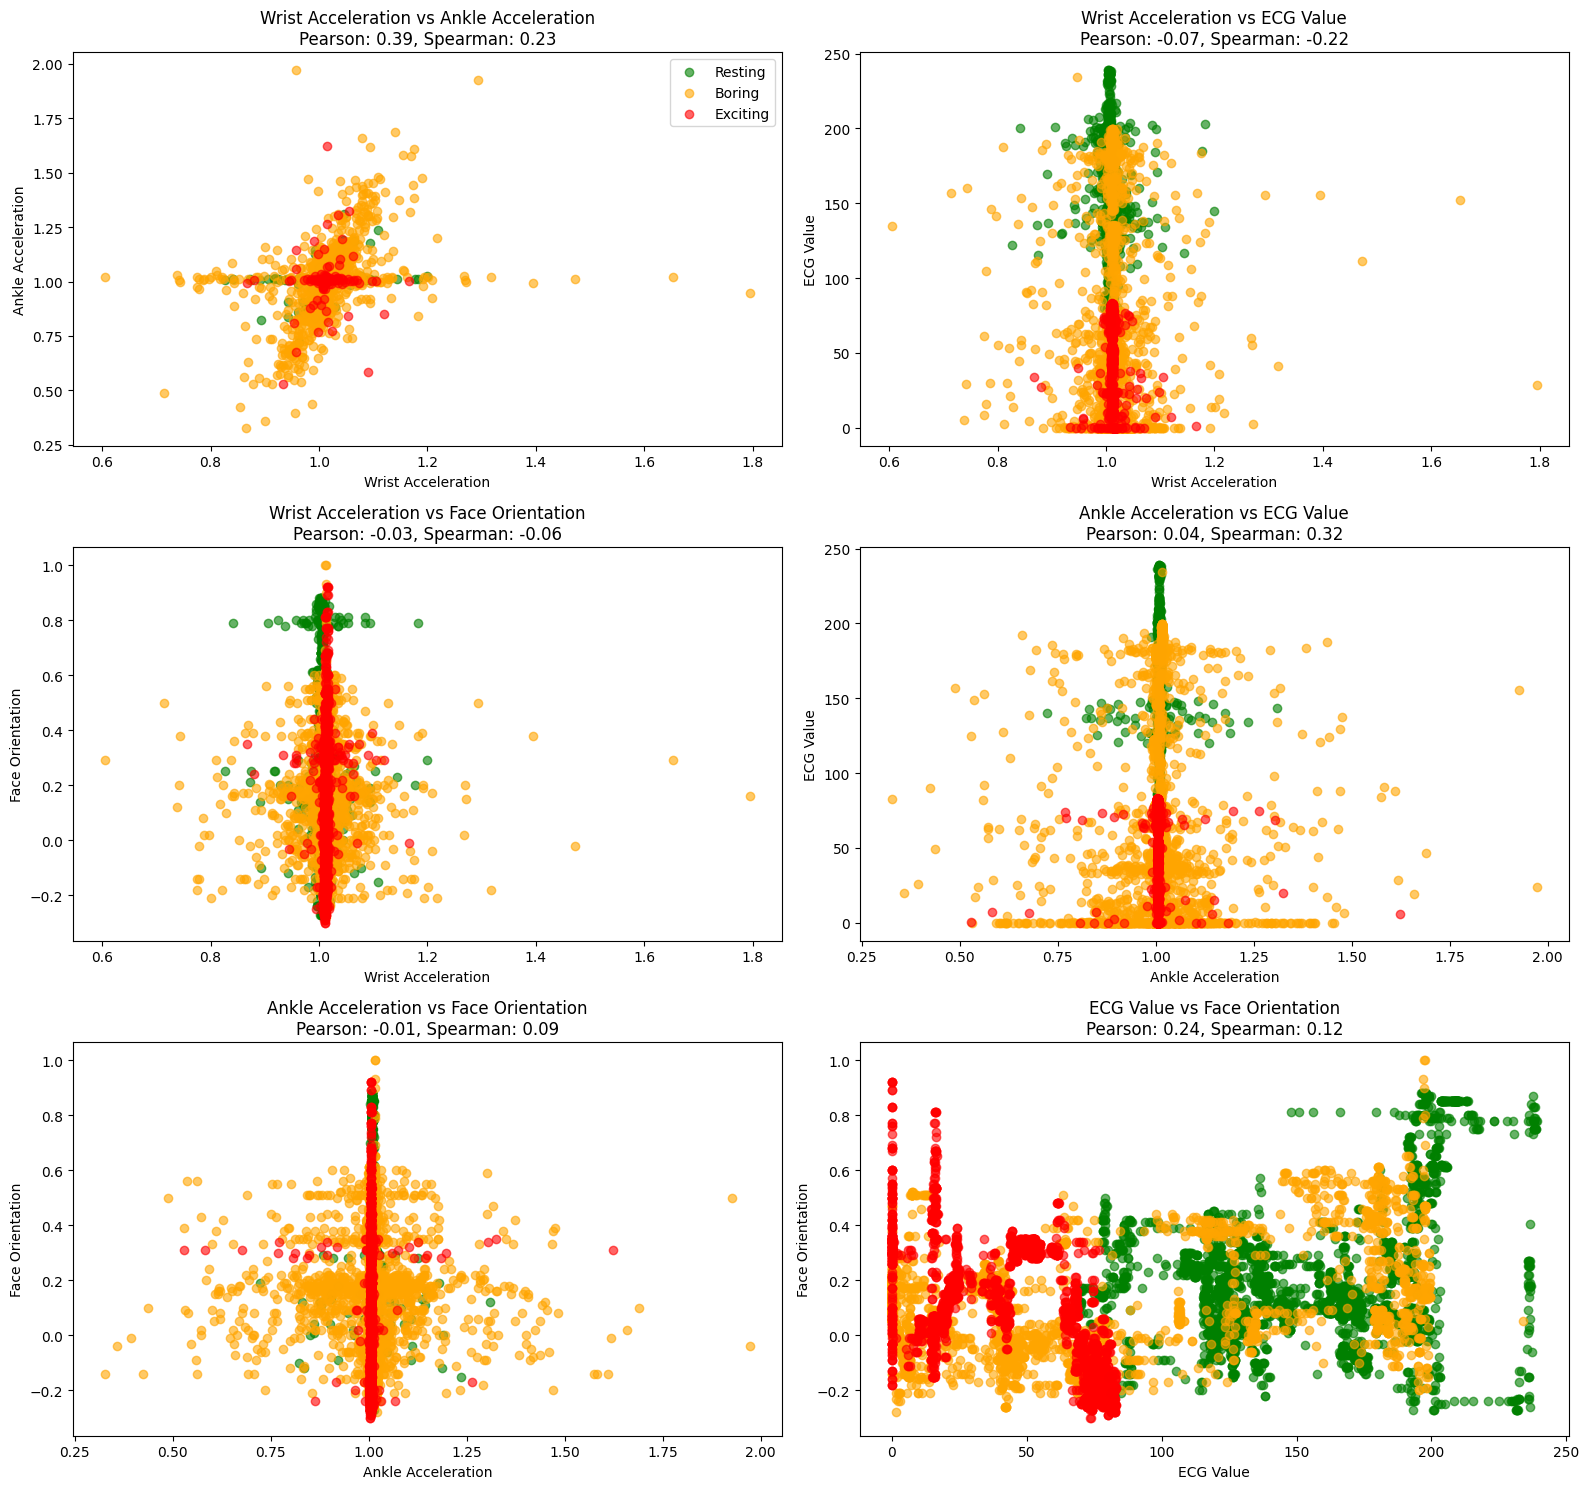

In [17]:
for participant in ['p1', 'p2']:
    create_pairwise_plots(participant)

In [22]:
def sliding_window_correlation(participant_id, window_size=60, step_size=30):

    if participant_id not in participant_data:
        print(f"No data available for {participant_id}")
        return

    df = participant_data[participant_id].copy()

    # Convert window size from seconds to number of samples
    sampling_rate = len(df) / (df['timestamp'].max() - df['timestamp'].min()).total_seconds()
    window_samples = int(window_size * sampling_rate)
    step_samples = int(step_size * sampling_rate)

    print(f"Sliding window analysis with window size: {window_samples} samples, step size: {step_samples} samples")

    # Define pairs of sensors to analyze (avoid repeated pairs)
    sensor_pairs = []
    for i, col1 in enumerate(sensor_columns):
        for j, col2 in enumerate(sensor_columns):
            if i < j:  # This ensures we only get each pair once
                sensor_pairs.append((col1, col2))

    timestamps = []
    correlations = {}

    for col1, col2 in sensor_pairs:
        pair_key = f"{col1}_vs_{col2}"
        correlations[pair_key] = []

    # Perform sliding window analysis
    for start_idx in range(0, len(df) - window_samples, step_samples):
        end_idx = start_idx + window_samples
        window_df = df.iloc[start_idx:end_idx]

        # Store timestamp at middle of window
        mid_idx = start_idx + window_samples // 2
        timestamps.append(df.iloc[mid_idx]['timestamp'])

        # Calculate correlations for this window
        window_corr = window_df[sensor_columns].corr()

        # Store correlation values for each pair
        for col1, col2 in sensor_pairs:
            pair_key = f"{col1}_vs_{col2}"
            correlations[pair_key].append(window_corr.loc[col1, col2])

    # Create a dataframe with the results
    result_df = pd.DataFrame({'timestamp': timestamps})
    for key, values in correlations.items():
        result_df[key] = values

    # Save results to CSV
    sliding_corr_path = os.path.join(base_dir, participant_id, 'correlation', 'sliding_window_correlation.csv')
    result_df.to_csv(sliding_corr_path, index=False)

    # Plot the sliding correlations
    plt.figure(figsize=(14, 10))

    for pair_key in correlations.keys():
        col1, col2 = pair_key.split("_vs_")
        label1 = sensor_labels[col1]
        label2 = sensor_labels[col2]
        plt.plot(result_df['timestamp'], result_df[pair_key], label=f"{label1} vs {label2}")

    plt.xlabel('Time')
    plt.ylabel('Pearson Correlation')
    plt.title(f'Sliding Window Correlation Analysis - {participant_id.upper()}')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add activity background shading
    activities_file = os.path.join(base_dir, participant_id, 'tests', 'activity_sessions.json')

    # If activities file doesn't exist, use hardcoded values
    if not os.path.exists(activities_file):
        if participant_id == 'p1':
            sessions = {
                'resting': {'start': '2025-03-11 23:42:00', 'end': '2025-03-11 23:48:00', 'color': 'green'},
                'boring': {'start': '2025-03-11 23:50:00', 'end': '2025-03-11 23:55:00', 'color': 'orange'},
                'exciting': {'start': '2025-03-11 23:57:00', 'end': '2025-03-12 00:02:00', 'color': 'red'}
            }
        else:  # p2
            sessions = {
                'resting': {'start': '2025-03-12 00:15:29', 'end': '2025-03-12 00:20:29', 'color': 'green'},
                'boring': {'start': '2025-03-12 00:21:00', 'end': '2025-03-12 00:26:00', 'color': 'orange'},
                'exciting': {'start': '2025-03-12 00:26:50', 'end': '2025-03-12 00:31:50', 'color': 'red'}
            }
    else:
        with open(activities_file, 'r') as f:
            sessions = json.load(f)

    for activity, session in sessions.items():
        start_time = pd.to_datetime(session['start'])
        end_time = pd.to_datetime(session['end'])
        color = session.get('color', 'blue')

        plt.axvspan(start_time, end_time, alpha=0.2, color=color, label=f"{activity.capitalize()} Activity")

    # Format x-axis to show time
    plt.gcf().autofmt_xdate()

    plt.tight_layout()

    # Save figure
    sliding_corr_fig_path = os.path.join(base_dir, participant_id, 'correlation', 'sliding_window_correlation.png')
    plt.savefig(sliding_corr_fig_path, dpi=300, bbox_inches='tight')

    # Display the figure
    plt.show()


### Participant P1 - Sliding Window Correlation

Sliding window analysis with window size: 600 samples, step size: 300 samples


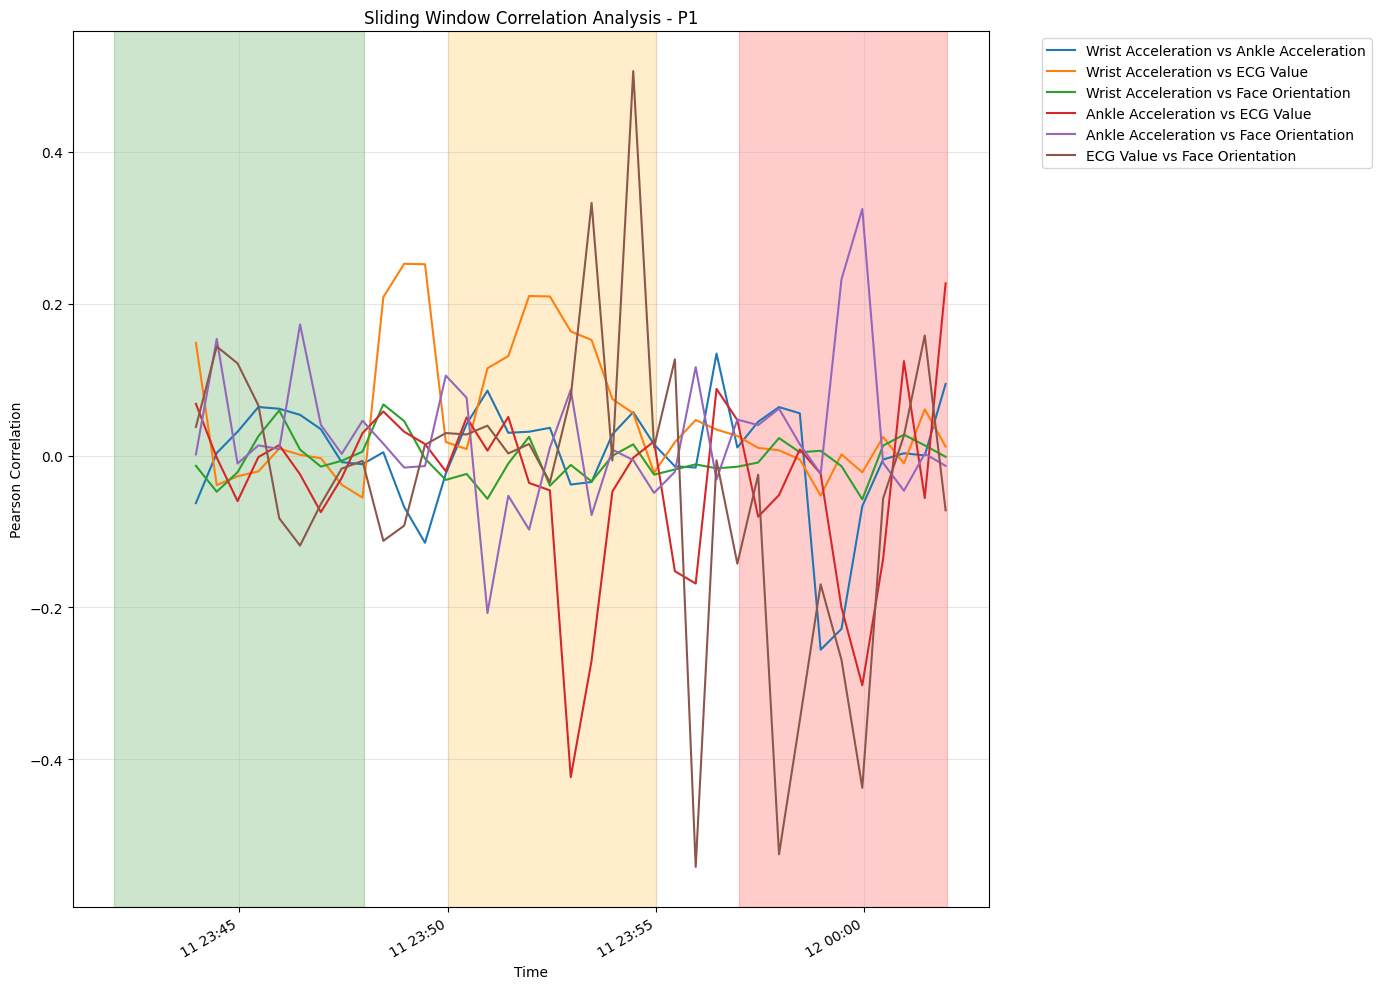

### Participant P2 - Sliding Window Correlation

Sliding window analysis with window size: 600 samples, step size: 300 samples


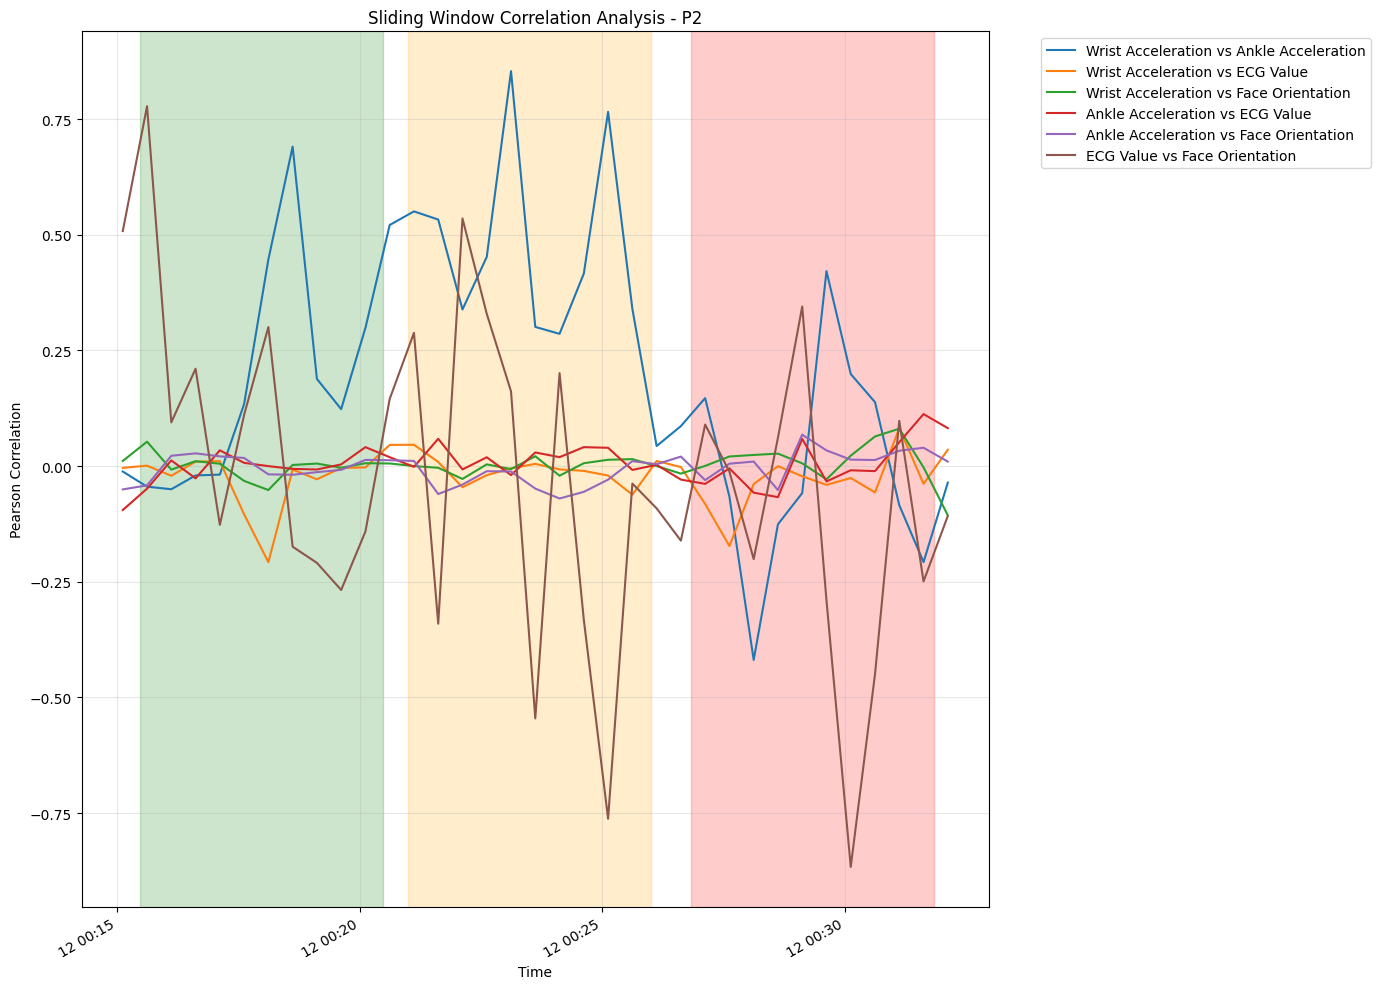

In [23]:
for participant in ['p1', 'p2']:
    sliding_window_correlation(participant)


1. **Sensor Relationships**:
   - Certain sensors show consistent correlation patterns across participants and activities


2. **Activity Effects**:
   - Different activity types produce distinct correlation patterns


3. **Individual Differences**:
   - While some correlation patterns are similar between participants
